# Introduction to `geoplanar`

### Mexico level 2 - municipalities & US counties

In [1]:
import geoplanar
import geopandas 

<AxesSubplot:>

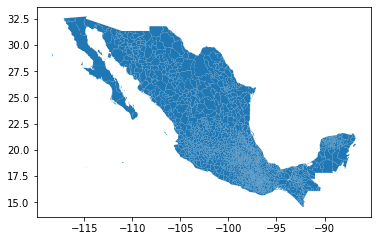

In [2]:
mex = geopandas.read_file("../geoplanar/datasets/mexico/lvl2/mex_admbnda_adm2_govmex_20210618.shp")
mex.plot() # municipios

In [3]:
us = geopandas.read_file("../geoplanar/datasets/us_counties/tl_2019_us_county.shp")
us = us.drop(us.index[us['STATEFP'].isin(['02', '15', '72', '69', '78', '60', '66'])]) # 11 DC
us = us.to_crs("EPSG:4326")
us.to_parquet("../geoplanar/datasets/uscounties.parquet")
us = geopandas.read_parquet("../geoplanar/datasets/uscounties.parquet")

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  after removing the cwd from sys.path.


<AxesSubplot:>

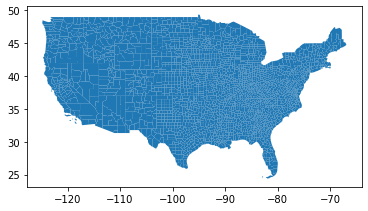

In [4]:
us.plot()

In [5]:
usmex = us.append(mex)

<AxesSubplot:>

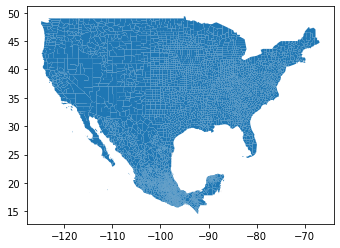

In [6]:
usmex.plot()

In [7]:
usmex.tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo
2452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,Puebla,MX21,México,MX,2020-06-23,2021-06-18,None
2453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zoquitlan,None,None,Puebla,MX21,México,MX,2020-06-23,2021-06-18,None
2454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,Veracruz de Ignacio de la Llave,MX30,México,MX,2020-06-23,2021-06-18,None
2455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zumpahuacan,None,None,México,MX15,México,MX,2020-06-23,2021-06-18,None
2456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,México,MX15,México,MX,2020-06-23,2021-06-18,None


In [8]:
usmex.shape

(5565, 32)

We have appended the Mexico gdf to the US gdf. For now, however, we are going to zoom in the border region to investigate things further:

In [9]:
from shapely.geometry import box

clipper = geopandas.GeoDataFrame(geometry =[box(-118.2,25.44,-95.17,34.45)])
                                 


In [10]:
usborder = geopandas.clip(us, clipper) # positional argument matters(see geopandas doc on clipper)

mexborder = geopandas.clip(mex, clipper)

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  """Entry point for launching an IPython kernel.
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
mexborder.shape

(262, 15)

In [12]:
usborder.shape

(265, 18)

<AxesSubplot:>

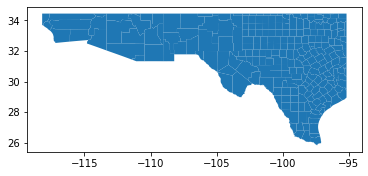

In [13]:
usborder.plot()

<AxesSubplot:>

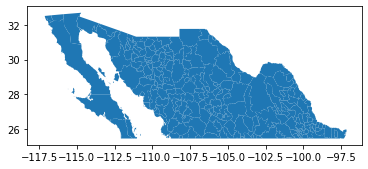

In [14]:
mexborder.plot()

In [15]:
usmex = usborder.append(mexborder)
usmex.reset_index(inplace=True)

<AxesSubplot:>

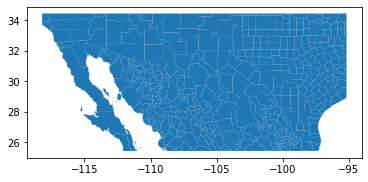

In [16]:
usmex.plot()

In [17]:
usmex.shape 

(527, 33)

number of geometries checks out

## Border discrepancies

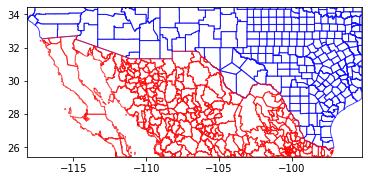

In [18]:
base = usborder.plot(alpha=0.7, facecolor='none', edgecolor='blue')
_ = mexborder.plot(alpha=0.7, facecolor='none', edgecolor='red', ax=base)
_ = base.set_xlim(-118.2, -95.17)
_ = base.set_ylim(25.44, 34.45)


Notice how some parts of the border have a slight purple color to them because of the overlaps.

## Fixing Overlaps/Overshoots

In [19]:
import pandas as pd

In [20]:
usborder['COUNTRY'] = 'US'
usborder.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTRY
2629,48,423,01383997,48423,Smith,Smith County,06,H1,G4020,540,46340,None,A,2386604273,73163661,+32.3770156,-095.2700409,"POLYGON ((-95.45658 32.27509, -95.45649 32.275...",US
1699,48,467,01384019,48467,Van Zandt,Van Zandt County,06,H1,G4020,None,None,None,A,2182248065,44152062,+32.5587866,-095.8369057,"POLYGON ((-96.07580 32.56364, -96.07580 32.563...",US
1843,48,499,01384035,48499,Wood,Wood County,06,H1,G4020,None,None,None,A,1671170961,130732368,+32.7835881,-095.3821664,"POLYGON ((-95.39787 32.96211, -95.39332 32.962...",US
2939,48,379,01383975,48379,Rains,Rains County,06,H1,G4020,None,None,None,A,594280898,76079674,+32.8705795,-095.7954400,"POLYGON ((-95.79922 32.77385, -95.79962 32.773...",US
607,48,223,01383897,48223,Hopkins,Hopkins County,06,H1,G4020,None,44860,None,A,1987629163,65639829,+33.1489673,-095.5654337,"POLYGON ((-95.74474 33.29677, -95.74450 33.296...",US


In [21]:
mexborder['COUNTRY'] = 'MEXICO'
mexborder.head()

,Shape_Leng,Shape_Area,ADM2_ES,ADM2_PCODE,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry,COUNTRY
1392,12.407851,0.531816,San Fernando,MX28035,None,None,None,Tamaulipas,MX28,México,MX,2020-06-23,2021-06-18,None,"POLYGON ((-97.97921 25.44000, -98.02898 25.440...",MEXICO
981,13.298980,0.348161,Matamoros,MX28022,None,None,None,Tamaulipas,MX28,México,MX,2020-06-23,2021-06-18,None,"MULTIPOLYGON (((-97.54358 25.44057, -97.54320 ...",MEXICO
1272,2.465661,0.142468,Río Bravo,MX28033,Rio Bravo,None,None,Tamaulipas,MX28,México,MX,2020-06-23,2021-06-18,None,"POLYGON ((-98.12911 26.07406, -98.12900 26.073...",MEXICO
2293,1.638987,0.080918,Valle Hermoso,MX28040,None,None,None,Tamaulipas,MX28,México,MX,2020-06-23,2021-06-18,None,"POLYGON ((-97.88582 25.50421, -97.88581 25.507...",MEXICO
1003,2.913147,0.226929,Méndez,MX28023,Mendez,None,None,Tamaulipas,MX28,México,MX,2020-06-23,2021-06-18,None,"POLYGON ((-98.14521 25.44621, -98.14494 25.446...",MEXICO


In [22]:
usmex2 = pd.concat([usborder, mexborder])

<AxesSubplot:>

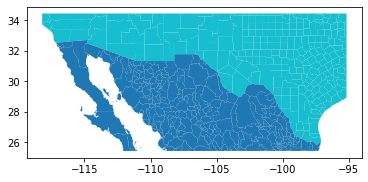

In [23]:
usmex2.plot('COUNTRY')

In [24]:
usmex2.shape

(527, 33)

In [25]:
usmex2 = usmex2.reset_index()

In [26]:
usmex2.area.sum()  # or use .sum() 

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


166.39323890249358

In [27]:
border_overlaps_removed = geoplanar.trim_overlaps(usmex2) # removing overlaps


In [28]:
border_overlaps_removed.area.sum() # mexico gets trimmed

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


166.3913868217395

In [29]:
border_overlaps_removed_1 = geoplanar.trim_overlaps(usmex2, largest=False)

In [30]:
border_overlaps_removed_1.area.sum() # us gets trimmed

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


166.3913868217395

In [31]:
#usmex2.explore(tooltip=False) # geopandas explroe function


We can see where the dataframes overlap if we zoom in. The Juarex/El Paso region has multiple instances where
we can see these issues. 
                               

## Fixing undershoots/holes

Trimming the overlaps removes the areas where points belong to both national polygons. What remains after this correction are holes (slivers) where points belong to neither polygon.

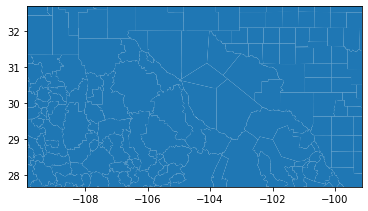

In [32]:
base = border_overlaps_removed.plot()
_ = base.set_xlim(-109.87, -99.14)   
_ = base.set_ylim(27.67, 32.68)

In [33]:
holes = geoplanar.holes(border_overlaps_removed) # holes left over after removing overlaps

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:47: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  _holes = dbu.explode()


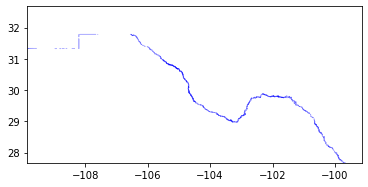

In [34]:
base = holes.plot(alpha=0.3, facecolor='none', edgecolor='blue')
_ = base.set_xlim(-109.87, -99.14)   
_ = base.set_ylim(27.67, 32.68)

In [35]:
holes.shape

(2191, 1)

For the entire border region there are 2191 holes that exist. These can be corrected, by merging the hole with the larger intersecting national polygon:

In [36]:
final = geoplanar.fill_holes(border_overlaps_removed) # creating final gdf 

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:47: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  _holes = dbu.explode()
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_do

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  left = neighbors[neighbors.area==neighbors.area.max()]
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:111: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  op='intersects')
/Users/ecv/anaconda3/envs/geoplanar_docs/lib/

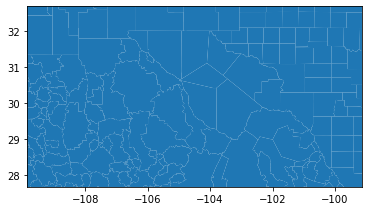

In [37]:
base = final.plot()
_ = base.set_xlim(-109.87, -99.14)   
_ = base.set_ylim(27.67, 32.68)

In [38]:
final.head()

,index,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo
0,2629,48,423,01383997,48423,Smith,Smith County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1699,48,467,01384019,48467,Van Zandt,Van Zandt County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1843,48,499,01384035,48499,Wood,Wood County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2939,48,379,01383975,48379,Rains,Rains County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,607,48,223,01383897,48223,Hopkins,Hopkins County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
h1 = geoplanar.holes(final)

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/geoplanar/hole.py:47: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  _holes = dbu.explode()


In [40]:
h1.shape 

(0, 1)

We have 0 holes after fixing overlaps, undershoots and filling in the holes.

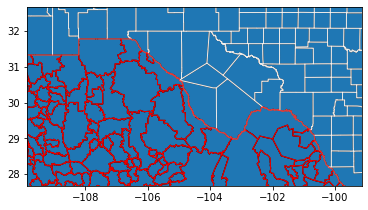

In [41]:
base = final.plot(edgecolor='k')
_ = usborder.plot(alpha=0.7, facecolor='none', edgecolor='white', ax = base)
_ = mexborder.plot(alpha=0.7, facecolor='none', edgecolor='red', ax=base)
_ = base.set_xlim(-109.87, -99.14)   
_ = base.set_ylim(27.67, 32.68)



In [42]:
final.area

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0      0.161007
1      0.213783
2      0.165828
3      0.064586
4      0.198439
         ...   
522    0.346923
523    0.846233
524    0.047813
525    0.118408
526    0.257544
Length: 527, dtype: float64

In [43]:
final.shape

(527, 34)

In [44]:
final.head()

,index,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo
0,2629,48,423,01383997,48423,Smith,Smith County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1699,48,467,01384019,48467,Van Zandt,Van Zandt County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1843,48,499,01384035,48499,Wood,Wood County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2939,48,379,01383975,48379,Rains,Rains County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,607,48,223,01383897,48223,Hopkins,Hopkins County,06,H1,G4020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After fixing the issues with overlaps, undershots, etc., we can check both gdf to see if we lost any geometries.

<AxesSubplot:>

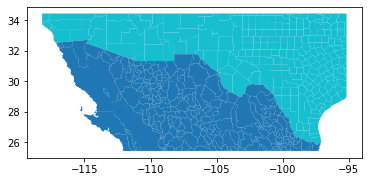

In [45]:
final.plot('COUNTRY')

In [46]:
usmex.shape

(527, 33)

In [47]:
final.shape

(527, 34)

Notice we gained a column because we assigned a 'COUNTRY' label to each border region.

In [48]:
usmex2.columns.symmetric_difference(usmex.columns)

Index(['COUNTRY'], dtype='object')

In [50]:
final.to_parquet("../geoplanar/datasets/usmex_clean/final_usmex.parquet")   

/Users/ecv/anaconda3/envs/geoplanar_docs/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.
